# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

In [6]:
# train['X'][1]
train['y']

array([[1],
       [9],
       [2],
       ...,
       [1],
       [6],
       [9]], dtype=uint8)

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
def get_image(raw_img):
    return np.rollaxis(raw_img,3)

In [5]:
train['X'].shape

(32, 32, 3, 73257)

In [7]:
get_image(train['X']).shape

(73257, 32, 32, 3)

In [4]:
def prepare_data(train, test):
    X_train_img = get_image(train['X'])
    y_train = train['y']
    y_train[y_train == 10] =0

    X_test_img = get_image(test['X'])
    y_test = test['y']
    y_test[y_test == 10] =0
    return X_train_img, y_train, X_test_img, y_test

X_train_img, y_train, X_test_img, y_test = prepare_data(train, test)
# X_train.shape  # (32, 32, 3, 73257)
# X_test.shape # (32, 32, 3, 26032)
# X_test.shape[3]

In [9]:
print(X_train_img.shape, X_test_img.shape)

(73257, 32, 32, 3) (26032, 32, 32, 3)


In [5]:
num_test_images = X_test_img.shape[0]
print(num_test_images)
random_inx = np.random.choice(num_test_images, 10)
print(random_inx)
# random_test_images = np.array([X_test[ ..., inx] for inx in  random_inx])
random_test_images = X_test_img[ random_inx, ...]
random_test_labels = y_test[random_inx, ...]

26032
[25718  6547  3027 19707 15196  3950 23864  5860  6031   643]


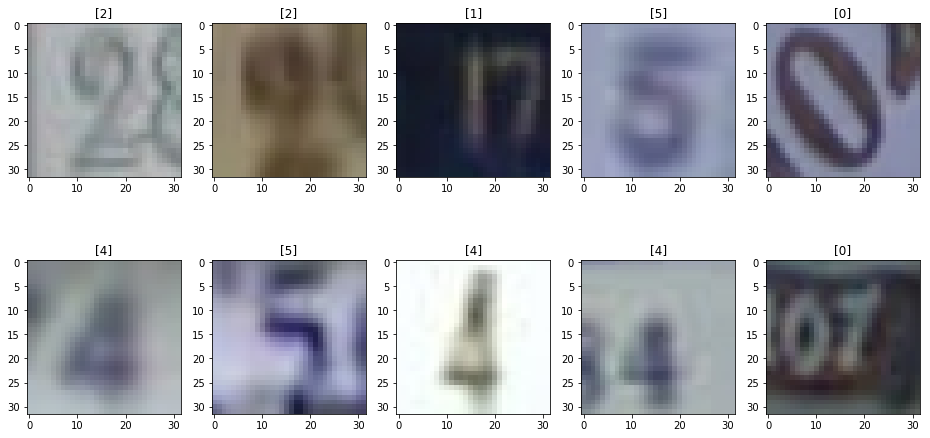

In [6]:
# columns = 5
# rows = 2

def plot_10_img_label(random_test_images,random_test_labels ):
    fig = plt.figure(figsize=(16, 8))
    ax = []
    for i, (image, label) in enumerate(zip( random_test_images, random_test_labels)):
        ax.append( fig.add_subplot(2, 5, i+1) )
        ax[-1].set_title(label)  # set title
        plt.imshow(image)
    plt.show()
    
plot_10_img_label(random_test_images,random_test_labels )

In [7]:
# from PIL import Image
# img = random_test_images[0]
# new_img = np.average(img, axis=-1) /255.
# new_img
# plt.imshow(img)
# plt.imshow(new_img)

def scale_image(img):
    return np.average(img, axis=-1) / 255.

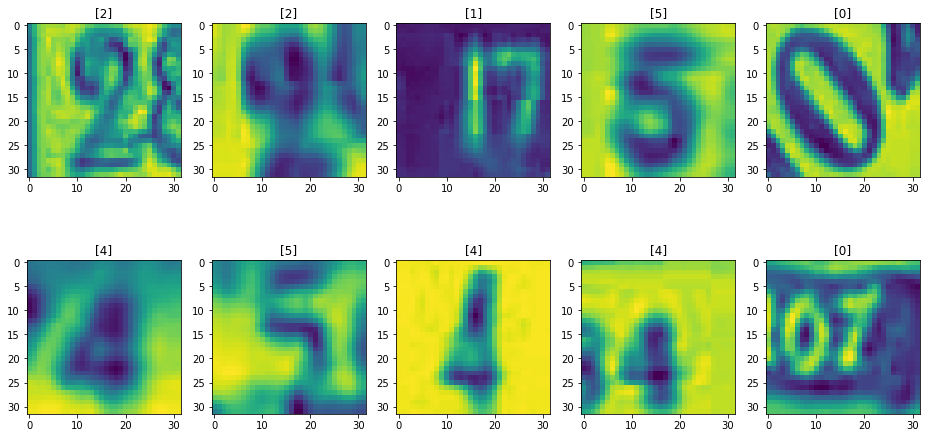

In [8]:
# fig = plt.figure(figsize=(16, 8))
# columns = 5
# rows = 2

# ax = []
# for i, (image, label) in enumerate(zip( random_test_images, random_test_labels)):
#     ax.append( fig.add_subplot(rows, columns, i+1) )
#     ax[-1].set_title(label)  # set title
#     plt.imshow(scale_image(image))
# plt.show()

scaled_random_test_images = [ scale_image(img) for img in random_test_images]

plot_10_img_label(scaled_random_test_images,random_test_labels )

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
def get_mlp_model():
    model = Sequential([
        Flatten(input_shape=(32,32,3)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics = ['accuracy','mae']
    )
    return model


In [13]:
model = get_mlp_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________


In [11]:
X_train_img = X_train_img / 255.
X_test_img = X_test_img / 255.

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    checkpoint_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'
    checkpoint = ModelCheckpoint('checkpoints/checkpoint_{epoch:03d}', 
                                save_weights_only=True,
                                save_freq='epoch')
    return checkpoint


def get_checkpoint_best_only(): 
    checkpoint_path = 'checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy')
    return checkpoint 

def get_early_stopping():
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
    return early_stopping

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [10]:
df = pd.DataFrame(y_train)
df.describe()

,0
count,73257.000000
mean,3.830105
std,2.689725
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,9.000000


In [37]:
y_train[y_train == 10] =0

df = pd.DataFrame(y_train)
df.describe()

In [18]:
history = model.fit(x=X_train_img,
                   y=y_train,
                   epochs=10,
                   batch_size=256,
                    validation_split=0.1,
#                    verbose=2,
                   callbacks=[checkpoint_every_epoch, checkpoint_best_only])

Train on 65931 samples, validate on 7326 samples
Epoch 1/10
65931/65931 [==============================] - 31s 471us/sample - loss: 2.1811 - accuracy: 0.2169 - mae: 3.7413 - val_loss: 2.0292 - val_accuracy: 0.2787 - val_mae: 3.7648
Epoch 2/10
65931/65931 [==============================] - 24s 357us/sample - loss: 1.8250 - accuracy: 0.3705 - mae: 3.7413 - val_loss: 1.6612 - val_accuracy: 0.4434 - val_mae: 3.7648
Epoch 3/10
65931/65931 [==============================] - 23s 349us/sample - loss: 1.4785 - accuracy: 0.5119 - mae: 3.7413 - val_loss: 1.3381 - val_accuracy: 0.5732 - val_mae: 3.7648
Epoch 4/10
65931/65931 [==============================] - 24s 357us/sample - loss: 1.2614 - accuracy: 0.5993 - mae: 3.7413 - val_loss: 1.1772 - val_accuracy: 0.6271 - val_mae: 3.7648
Epoch 5/10
65931/65931 [==============================] - 23s 349us/sample - loss: 1.1493 - accuracy: 0.6406 - mae: 3.7413 - val_loss: 1.0871 - val_accuracy: 0.6671 - val_mae: 3.7648
Epoch 6/10
65931/65931 [============

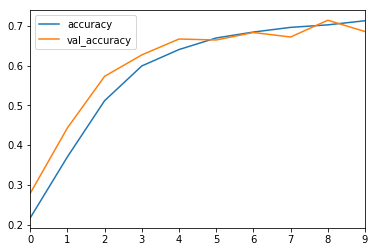

In [19]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

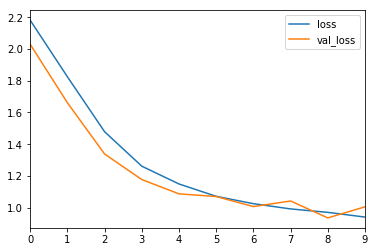

In [20]:
df.plot(y=['loss', 'val_loss'])

In [21]:
def get_test_loss_accuracy(model, x_test, y_test):
    test_loss, test_acc, test_mae = model.evaluate(x=x_test, y=y_test, verbose=0)
    print(f'loss: {test_loss:0.3f} accuracy: {test_acc:0.3f}')

In [22]:
# print(X_test_img.shape)

# rlt = model.evaluate(x=X_test_img, y=y_test, verbose=0)

# print(rlt)

# Compute and display the loss and accuracy of the trained model on the test set
get_test_loss_accuracy(model, X_test_img, y_test)

loss: 1.132 accuracy: 0.664


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [14]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

def get_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu',padding='SAME',input_shape=(32,32,3)),
        MaxPooling2D((3,3)),
        Conv2D(16,(3,3),  activation='relu' ,padding='SAME'),
        BatchNormalization(),
        MaxPooling2D((3,3)),   
        Dropout(0.25),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.25),        
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics = ['accuracy','mae']
    )
    return model

In [15]:
model_cnn = get_cnn_model()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)              

In [16]:
def get_checkpoint_every_epoch_cnn():
    checkpoint_path = 'checkpoints_every_epoch_cnn/checkpoint_{epoch:03d}'
    checkpoint = ModelCheckpoint('checkpoints/checkpoint_{epoch:03d}', 
                                save_weights_only=True,
                                save_freq='epoch')
    return checkpoint


def get_checkpoint_best_only_cnn(): 
    checkpoint_path = 'checkpoints_best_only_cnn/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy')
    return checkpoint 

In [17]:
checkpoint_every_epoch = get_checkpoint_every_epoch_cnn()
checkpoint_best_only = get_checkpoint_best_only_cnn()
early_stopping = get_early_stopping()

In [18]:
cnn_history = model_cnn.fit(x=X_train_img,
                   y=y_train,
                   epochs=10,
                   batch_size=32,
                    validation_split=0.1,
#                    verbose=2,
                   callbacks=[checkpoint_every_epoch, checkpoint_best_only])

Train on 65931 samples, validate on 7326 samples
Epoch 1/10
65931/65931 [==============================] - 277s 4ms/sample - loss: 1.7658 - accuracy: 0.3831 - mae: 3.7413 - val_loss: 1.0713 - val_accuracy: 0.6492 - val_mae: 3.7648
Epoch 2/10
65931/65931 [==============================] - 259s 4ms/sample - loss: 1.1154 - accuracy: 0.6313 - mae: 3.7413 - val_loss: 0.8287 - val_accuracy: 0.7554 - val_mae: 3.7648
Epoch 3/10
65931/65931 [==============================] - 259s 4ms/sample - loss: 0.9780 - accuracy: 0.6841 - mae: 3.7413 - val_loss: 0.7213 - val_accuracy: 0.7786 - val_mae: 3.7648
Epoch 4/10
65931/65931 [==============================] - 258s 4ms/sample - loss: 0.9236 - accuracy: 0.7007 - mae: 3.7413 - val_loss: 0.6978 - val_accuracy: 0.7843 - val_mae: 3.7648
Epoch 5/10
65931/65931 [==============================] - 259s 4ms/sample - loss: 0.8893 - accuracy: 0.7143 - mae: 3.7413 - val_loss: 0.6813 - val_accuracy: 0.7974 - val_mae: 3.7648
Epoch 6/10
65931/65931 [=================

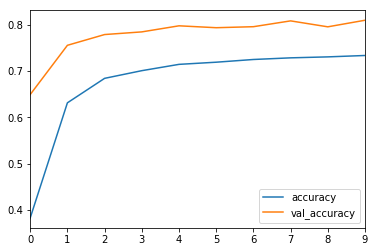

In [19]:
cnn_df = pd.DataFrame(cnn_history.history)
cnn_df.plot(y=['accuracy', 'val_accuracy'])

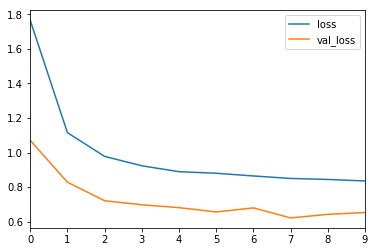

In [20]:
cnn_df.plot(y=['loss', 'val_loss'])

In [ ]:
get_test_loss_accuracy(model_cnn, X_test_img, y_test)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [21]:
def get_model_best_epoch(model,path):
    model.load_weights(path)
    return model 

In [22]:
mlp_model_new = get_mlp_model()
mlp_model_new = get_model_best_epoch(mlp_model_new, 'checkpoints_best_only/checkpoint')

In [23]:
cnn_model_new = get_cnn_model()
cnn_model_new = get_model_best_epoch(cnn_model_new, 'checkpoints_best_only_cnn/checkpoint')

In [24]:
def models_random_n_test(model_mlp, model_cnn, test_images,test_labels,N = 5):
    num_test_images = test_images.shape[0]
    random_inx = np.random.choice(num_test_images, N)
    random_test_images = test_images[random_inx, ...]
    random_test_labels = test_labels[random_inx, ...]

    mlp_predictions = model_mlp.predict(random_test_images)
    cnn_predictions = model_cnn.predict(random_test_images)
    return mlp_predictions,cnn_predictions ,random_test_images,random_test_labels

In [32]:
def plot_random_n_result(mlp_predictions,cnn_predictions ,random_test_images,random_test_labels, N=5 ):
    fig, axes = plt.subplots(N, 3, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)
    for i, (mlp_prediction,cnn_prediction, image, label) in enumerate(zip(mlp_predictions,cnn_predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        
        axes[i, 1].bar(np.arange(len(mlp_prediction)), mlp_prediction)
        axes[i, 1].set_xticks(np.arange(len(mlp_prediction)))
        axes[i, 1].set_title(f"Categorical distribution. MLP Model prediction: {np.argmax(mlp_prediction)}")
        
        axes[i, 2].bar(np.arange(len(cnn_prediction)), cnn_prediction)
        axes[i, 2].set_xticks(np.arange(len(cnn_prediction)))
        axes[i, 2].set_title(f"Categorical distribution. CNN Model prediction: {np.argmax(cnn_prediction)}")

    plt.show()

In [28]:
mlp_predictions,cnn_predictions ,random_test_images,random_test_labels= models_random_n_test(mlp_model_new,cnn_model_new, X_test_img,y_test)

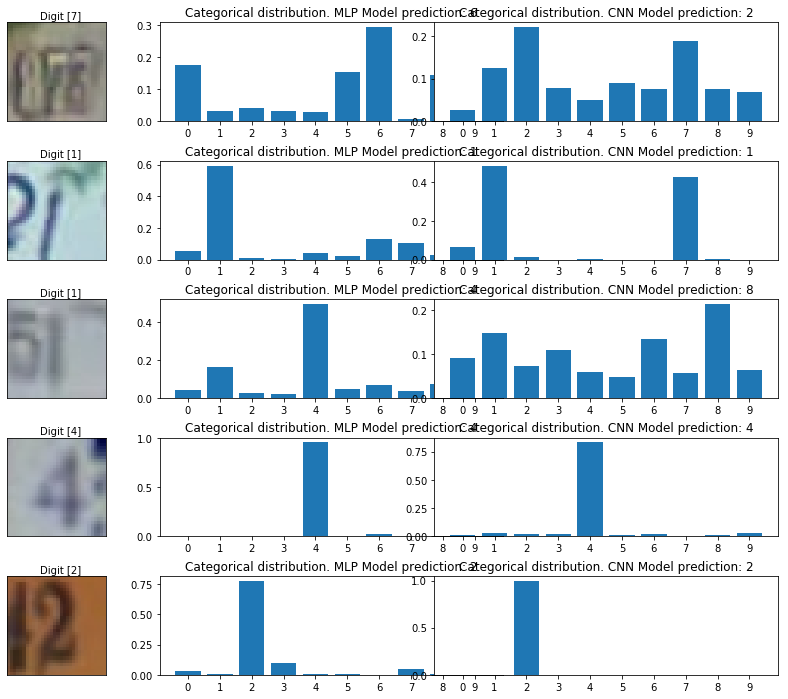

In [33]:
plot_random_n_result(mlp_predictions,cnn_predictions ,random_test_images,random_test_labels)